# Face Attention Maps Visualization

In [28]:
from PIL import Image
import requests
import os
import numpy as np
from io import BytesIO
import torch
from torch import nn
from backbone.model_irse import IR_50, IR_152, Backbone
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.transforms as T
import torch.nn.functional as F
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [29]:
def init_model(model, param, device):
    m = model([112,112]).to(device)
    m.load_state_dict(torch.load(param, map_location='cuda'))
    m.eval()
    return m

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IR50 = init_model(IR_50, './pretraining_model/backbone_ir50_ms1m_epoch120.pth', device)

In [38]:
class ResNet50AT(Backbone):
    """Attention maps of ResNet-50.
    
    Overloaded ResNet model to return attention maps.
    """
    def __init__(self, input_size, num_layers, mode='ir'):
        super(ResNet50AT, self).__init__(input_size, num_layers, mode='ir')
    def forward(self, x):
        x = self.input_layer(x)
        xx=[]
        for module in self.body._modules.values():
            x = module(x)
            xx.append(x)
        x = self.output_layer(x)

        
        return [g.pow(2).mean(1) for g in (xx)]

model = ResNet50AT([112, 112], 50, 'ir')
model.load_state_dict(IR50.state_dict())

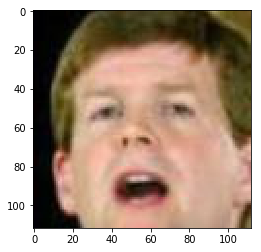

In [39]:
im = np.ascontiguousarray(Image.open(os.path.abspath(os.path.dirname(os.getcwd())) + '/origin_images/' + '00001.jpg')  , dtype=np.uint8)
plt.imshow(im);


In [42]:
tr_center_crop = T.Compose([
        T.ToPILImage(),
        T.Resize(112),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

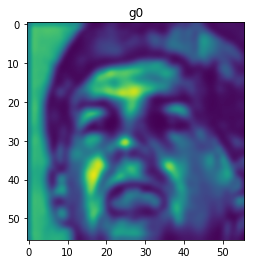

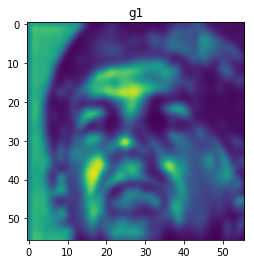

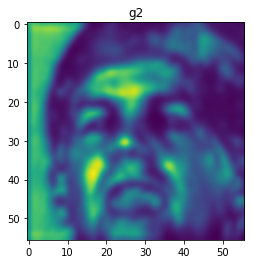

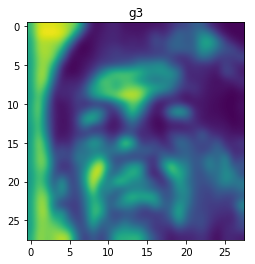

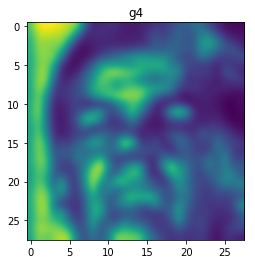

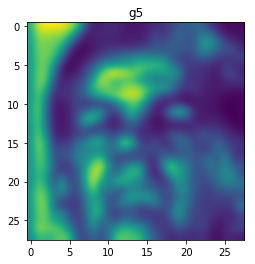

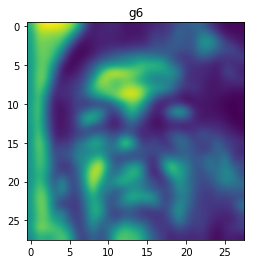

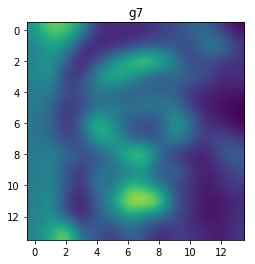

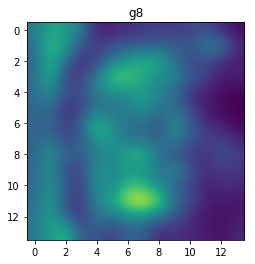

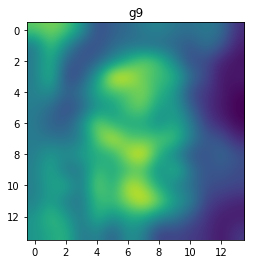

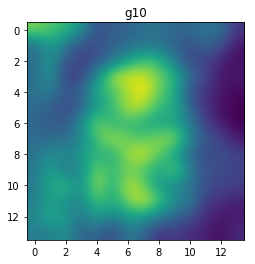

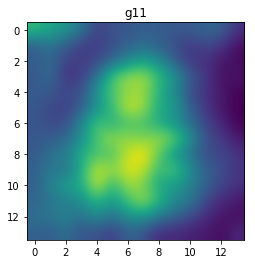

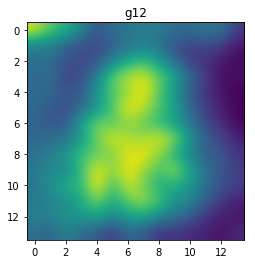

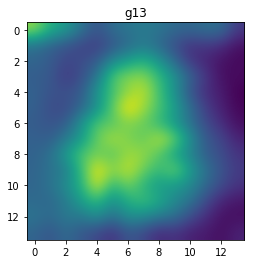

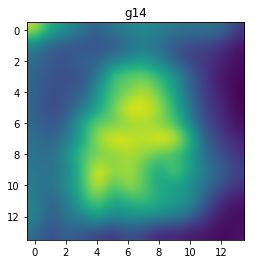

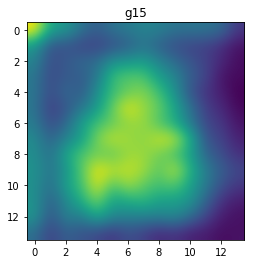

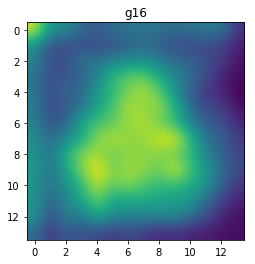

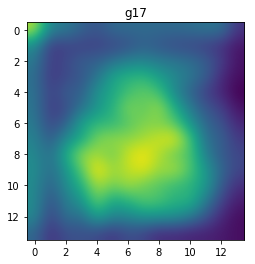

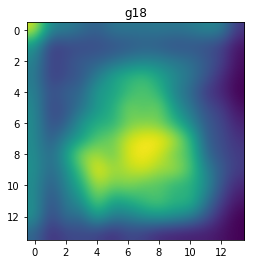

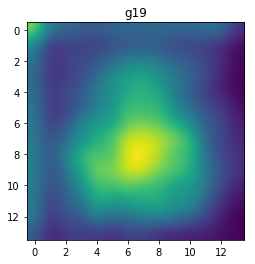

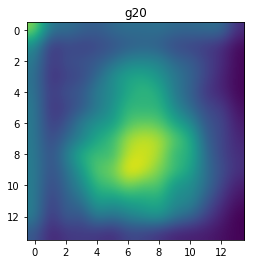

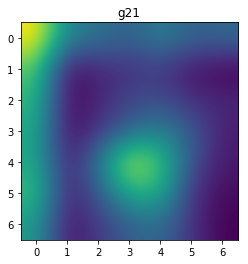

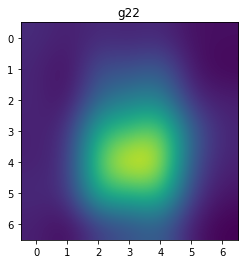

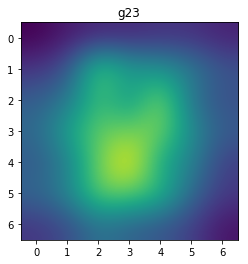

In [43]:
model.eval()
with torch.no_grad():
    x = tr_center_crop(im).unsqueeze(0)
    gs = model(x)

for i, g in enumerate(gs):
    plt.imshow(g[0], interpolation='bicubic')
    plt.title(f'g{i}')
    plt.show()